In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from multiprocessing import Pool, cpu_count
import gzip
import re
from scipy.spatial import cKDTree


class GoldhirschWeinhartCoarseGrainer:
    """
    Goldhirsch-Weinhart coarse-graining implementation for DEM Simulation data
    """
    
    def __init__(self, folder_path, pattern='Dump.shear_fixed_Load_1wall.*', 
                 max_frames=np.inf, n_cores=None):
        self.folder_path = Path(folder_path)
        self.pattern = pattern
        self.max_frames = max_frames
        self.n_cores = n_cores or cpu_count()
        
        # Particle type densities (kg/m³)
        self.type_density = {1: 2600.0, 2: 2600.0, 3: 2600.0}
        
        # Coarse-graining parameters (will be auto-adjusted based on data)
        self.w = None  # Coarse-graining width (set automatically)
        self.support_fac = 3.0  # Support factor for kernel
        self.support = None
        
        # Grid parameters
        self.dx = None  # Grid spacing (set automatically)
        
        print(f"Initializing Goldhirsch-Weinhart coarse grainer:")
        print(f"  Support factor: {self.support_fac}")
        print(f"  CPU cores: {self.n_cores}")
        
    # def lucy_kernel(self, r, w):
    #     """
    #     Lucy kernel function (normalized)
    #     φ(r) = (1 + 3r/w)(1 - r/w)³ for r < w, else 0
    #     """
    #     q = r / w
    #     kernel = np.zeros_like(r)
    #     mask = q < 1.0
        
    #     # Lucy kernel with normalization factor
    #     # In 3D: normalization = 105/(16πw³)
    #     # In 2D: normalization = 5/(πw²)
    #     norm_3d = 105.0 / (16.0 * np.pi * w**3)
        
    #     kernel[mask] = norm_3d * (1 + 3*q[mask]) * (1 - q[mask])**3
    #     return kernel
    
    def gaussian_kernel(self, r, w):
        """
        Gaussian kernel function
        φ(r) = (1/√(2πw²)) exp(-r²/(2w²))
        """
        norm = 1.0 / (np.sqrt(2 * np.pi) * w)**3
        return norm * np.exp(-r**2 / (2 * w**2))
    
    def find_and_sort_files(self):
        """Find and sort LAMMPS dump files by timestep"""
        print(f"Looking for files in: {self.folder_path}")
        
        if not self.folder_path.exists():
            raise FileNotFoundError(f"Folder does not exist: {self.folder_path}")
            
        files = list(self.folder_path.glob(self.pattern))
        if not files:
            raise FileNotFoundError(f"No files found matching pattern: {self.pattern}")
            
        print(f"Found {len(files)} files matching pattern")
        
        # Extract timesteps
        timesteps = []
        valid_files = []
        patterns = [
            r'\.(\d+)$',
            r'\.(\d+)\.gz$',
            r'\.(\d+)\..*$',
            r'wall\.(\d+)',
            r'_(\d+)$',
            r'(\d+)$'
        ]
        
        for file in files:
            timestep = None
            for pattern in patterns:
                match = re.search(pattern, file.name)
                if match:
                    timestep = int(match.group(1))
                    break
            
            if timestep is not None:
                timesteps.append(timestep)
                valid_files.append(file)
                
        if not valid_files:
            raise ValueError("No files with extractable timesteps found")
            
        # Sort by timestep
        sorted_indices = np.argsort(timesteps)
        self.files = [valid_files[i] for i in sorted_indices]
        self.timesteps = [timesteps[i] for i in sorted_indices]
        
        print(f"Processing {len(self.files)} files with valid timesteps")
        return self.files[:int(self.max_frames)]
    
    def read_lammps_dump(self, filename):
        """Read a single LAMMPS dump file"""
        filepath = Path(filename)
        
        opener = gzip.open if filepath.suffix == '.gz' else open
            
        with opener(filepath, 'rt') as f:
            # Read timestep
            line = f.readline()
            if not line.startswith('ITEM: TIMESTEP'):
                raise ValueError(f"Expected TIMESTEP header")
            timestep = int(f.readline().strip())
            
            # Read number of atoms
            line = f.readline()
            if not line.startswith('ITEM: NUMBER OF ATOMS'):
                raise ValueError(f"Expected NUMBER OF ATOMS header")
            N = int(f.readline().strip())
            
            # Read box bounds
            line = f.readline()
            if not line.startswith('ITEM: BOX BOUNDS'):
                raise ValueError(f"Expected BOX BOUNDS header")
            
            # Parse boundary conditions from BOX BOUNDS line
            boundary_types = line.split()[3:6] if len(line.split()) > 3 else ['pp', 'pp', 'pp']
                
            bounds = []
            for _ in range(3):
                line = f.readline().strip()
                if line.startswith('ITEM:'):
                    break
                vals = list(map(float, line.split()))
                if len(vals) >= 2:
                    bounds.append(vals[:2])
                    
            bounds = np.array(bounds)
            dim = len(bounds)
            
            # Read atoms
            if not line.startswith('ITEM: ATOMS'):
                line = f.readline()
            
            cols = line.split()[2:]  # Column headers
            
            # Read atom data
            data = []
            for _ in range(N):
                line = f.readline().strip()
                if line:  # Skip empty lines
                    data.append(list(map(float, line.split())))
                
            data = np.array(data)
            
        # Parse data into structured frame
        frame = {
            'timestep': timestep,
            'N': N,
            'box_bounds': bounds,
            'boundary_types': boundary_types,
            'dim': dim,
            'x': np.zeros((N, max(2, dim))),
            'v': np.zeros((N, max(2, dim))),
            'type': np.ones(N, dtype=int),
            'radius': np.ones(N) * 0.005,  # Default 0.005 based on your data
            'mass': None,
            'id': None
        }
        
        # Map columns
        for i, col in enumerate(cols):
            col = col.lower()
            if col == 'id':
                frame['id'] = data[:, i].astype(int)
            elif col == 'type':
                frame['type'] = data[:, i].astype(int)
            elif col in ['x', 'xu']:
                frame['x'][:, 0] = data[:, i]
            elif col in ['y', 'yu']:
                frame['x'][:, 1] = data[:, i]
            elif col in ['z', 'zu'] and dim >= 3:
                frame['x'][:, 2] = data[:, i]
            elif col == 'vx':
                frame['v'][:, 0] = data[:, i]
            elif col == 'vy':
                frame['v'][:, 1] = data[:, i]
            elif col == 'vz' and dim >= 3:
                frame['v'][:, 2] = data[:, i]
            elif col in ['radius', 'r']:
                frame['radius'] = data[:, i]
            elif col in ['mass', 'm']:
                frame['mass'] = data[:, i]
        
        # Print frame info
        # print(f"    Box: x=[{bounds[0,0]:.3f}, {bounds[0,1]:.3f}], "
        #       f"y=[{bounds[1,0]:.3f}, {bounds[1,1]:.3f}], "
        #       f"z=[{bounds[2,0]:.3f}, {bounds[2,1]:.3f}]")
        # print(f"    Particle types: {np.unique(frame['type'])}")
        # print(f"    Radius range: [{np.min(frame['radius']):.6f}, {np.max(frame['radius']):.6f}]")
        # print(f"    Velocity range: vx=[{np.min(frame['v'][:,0]):.6f}, {np.max(frame['v'][:,0]):.6f}], "
        #       f"vy=[{np.min(frame['v'][:,1]):.6f}, {np.max(frame['v'][:,1]):.6f}]")
                
        return frame
    
    def read_all_frames(self):
        """Read all LAMMPS dump files"""
        files = self.find_and_sort_files()
        frames = []
        
        for i, file in enumerate(files):
            # print(f"Reading file {i+1}/{len(files)}: {file.name}")
            try:
                frame = self.read_lammps_dump(file)
                frames.append(frame)
                # print(f"  ✓ Success: {frame['N']} atoms, timestep {frame['timestep']}")
            except Exception as e:
                print(f"  ✗ Error: {str(e)}")
                import traceback
                traceback.print_exc()
                
        if not frames:
            raise RuntimeError("No frames successfully read")
            
        print(f"\n✓ Successfully read {len(frames)} frames")
        self.frames = frames
        return frames
    
    def compute_particle_mass(self, frame):
        """Compute particle masses if not provided"""
        if frame['mass'] is not None:
            return frame['mass']
        
        # Calculate mass from volume and density
        volume = (4.0/3.0) * np.pi * frame['radius']**3
        mass = np.array([volume[i] * self.type_density.get(frame['type'][i], 2600.0) 
                        for i in range(frame['N'])])
        return mass
    
    def estimate_coarse_graining_width(self, frame):
        """
        Estimate appropriate coarse-graining width based on particle spacing
        """
        # Calculate average nearest neighbor distance
        from scipy.spatial import cKDTree
        positions = frame['x'][:, :frame['dim']]
        
        # Sample if too many particles
        n_sample = min(1000, len(positions))
        sample_idx = np.random.choice(len(positions), n_sample, replace=False)
        
        tree = cKDTree(positions)
        distances, _ = tree.query(positions[sample_idx], k=2)
        avg_spacing = np.mean(distances[:, 1])  # Second neighbor (first is itself)
        
        # Set w to be 2-3 times the average spacing
        w = 2.5 * avg_spacing
        
        print(f"Estimated parameters:")
        print(f"  Average particle spacing: {avg_spacing:.6f}")
        print(f"  Coarse-graining width (w): {w:.6f}")
        print(f"  Support radius: {self.support_fac * w:.6f}")
        
        return w
    
    def coarse_grain_velocity(self, frame, grid_points, kernel_type = None, w=None):
        """
        Coarse-grain velocity field using Goldhirsch-Weinhart method
        
        v(r) = Σ_i m_i v_i φ(|r - r_i|, w) / Σ_i m_i φ(|r - r_i|, w)
        
        Parameters:
        -----------
        frame : dict
            Frame data with positions, velocities, etc.
        grid_points : ndarray
            Points at which to evaluate the field (N_grid x dim)
        kernel_type : str
            'lucy' or 'gaussian'
        w : float
            Coarse-graining width (if None, auto-estimate)
        
        Returns:
        --------
        velocity_field : ndarray (N_grid x dim)
        density_field : ndarray (N_grid,)
        """
        # Auto-estimate coarse-graining width if not provided
        if w is None:
            w = self.estimate_coarse_graining_width(frame)
        else:
            print(f"Using provided coarse-graining width: {w}")
        
        support = self.support_fac * w
        
        positions = frame['x'][:, :frame['dim']]
        velocities = frame['v'][:, :frame['dim']]
        mass = self.compute_particle_mass(frame)
        
        # Build KD-tree for efficient neighbor search
        tree = cKDTree(positions)
        
        # Select kernel
        kernel_func = self.gaussian_kernel
        
        n_grid = len(grid_points)
        velocity_field = np.zeros((n_grid, frame['dim']))
        density_field = np.zeros(n_grid)
        
        print(f"Coarse-graining {n_grid} grid points...")
        
        # Query neighbors within support radius
        for i, grid_pt in enumerate(grid_points):
            if i % 1000 == 0:
                print(f"  Progress: {i}/{n_grid} points")
            
            # Find particles within support radius
            indices = tree.query_ball_point(grid_pt[:frame['dim']], support)
            
            if not indices:
                continue
            
            # Compute distances
            r_vec = positions[indices] - grid_pt[:frame['dim']]
            r = np.linalg.norm(r_vec, axis=1)
            
            # Compute kernel weights
            weights = kernel_func(r, w) * mass[indices]
            
            # Coarse-grained velocity
            total_weight = np.sum(weights)
            if total_weight > 1e-12:
                velocity_field[i] = np.sum(weights[:, None] * velocities[indices], axis=0) / total_weight
                density_field[i] = total_weight
        
        print("  ✓ Coarse-graining complete")
        return velocity_field, density_field
    
    def compute_velocity_profile(self, frame, direction='y', velocity_component='x', 
                                n_bins=50, kernel_type = None, w=None):
        """
        Compute 1D velocity profile along a direction (useful for shear flows)
        
        Parameters:
        -----------
        frame : dict
            Frame data
        direction : str or int
            Direction to bin along ('x', 'y', 'z' or 0, 1, 2)
        velocity_component : str or int
            Velocity component to average ('x', 'y', 'z' or 0, 1, 2)
        n_bins : int
            Number of bins
        kernel_type : str
            'lucy' or 'gaussian'
        w : float
            Coarse-graining width
        
        Returns:
        --------
        bin_centers : ndarray
            Bin center positions
        velocity_profile : ndarray
            Average velocity in each bin
        velocity_std : ndarray
            Standard deviation in each bin
        """
        # Convert string directions to indices
        dir_map = {'x': 0, 'y': 1, 'z': 2}
        if isinstance(direction, str):
            dir_idx = dir_map[direction.lower()]
        else:
            dir_idx = direction
            
        if isinstance(velocity_component, str):
            vel_idx = dir_map[velocity_component.lower()]
        else:
            vel_idx = velocity_component
        
        # Get positions and velocities
        positions = frame['x'][:, dir_idx]
        velocities = frame['v'][:, vel_idx]
        
        # Auto-estimate w if needed
        if w is None:
            w = self.estimate_coarse_graining_width(frame)
        
        # Create bins
        bounds = frame['box_bounds'][dir_idx]
        bin_edges = np.linspace(bounds[0], bounds[1], n_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        velocity_profile = np.zeros(n_bins)
        velocity_std = np.zeros(n_bins)
        particle_count = np.zeros(n_bins)
        
        # Bin particles
        for i, center in enumerate(bin_centers):
            # Find particles within kernel support
            distances = np.abs(positions - center)
            mask = distances < (self.support_fac * w)
            
            if np.sum(mask) > 0:
                # Weight by kernel
                kernel_func = self.gaussian_kernel
                weights = kernel_func(distances[mask], w)
                
                velocity_profile[i] = np.average(velocities[mask], weights=weights)
                velocity_std[i] = np.std(velocities[mask])
                particle_count[i] = np.sum(mask)
        
        print(f"Velocity profile computed:")
        print(f"  Direction: {direction} (index {dir_idx})")
        print(f"  Velocity component: {velocity_component} (index {vel_idx})")
        print(f"  Bins with particles: {np.sum(particle_count > 0)}/{n_bins}")
        
        return bin_centers, velocity_profile, velocity_std, particle_count
    
    def create_grid(self, frame, grid_type='uniform', n_points=None, dx=None):
        """
        Create grid points for coarse-graining
        
        Parameters:
        -----------
        frame : dict
            Frame data with box bounds
        grid_type : str
            'uniform' or 'adaptive'
        n_points : int or tuple
            Number of grid points (per dimension if tuple)
        dx : float or array
            Grid spacing (alternative to n_points)
        """
        bounds = frame['box_bounds']
        dim = frame['dim']
        
        if n_points is None and dx is None:
            # Estimate based on particle spacing
            w = self.estimate_coarse_graining_width(frame)
            dx = w / 2.0  # Grid spacing = half the coarse-graining width
            print(f"Using grid spacing: {dx:.6f}")
        
        if n_points is None:
            # Calculate based on dx
            if np.isscalar(dx):
                dx = np.array([dx] * dim)
            n_points = tuple(int((bounds[i, 1] - bounds[i, 0]) / dx[i]) 
                           for i in range(dim))
        
        if isinstance(n_points, int):
            n_points = tuple([n_points] * dim)
        
        # Create meshgrid
        if dim == 2:
            x = np.linspace(bounds[0, 0], bounds[0, 1], n_points[0])
            y = np.linspace(bounds[1, 0], bounds[1, 1], n_points[1])
            xx, yy = np.meshgrid(x, y)
            grid_points = np.column_stack([xx.ravel(), yy.ravel()])
            grid_shape = (n_points[1], n_points[0])
        else:  # 3D
            x = np.linspace(bounds[0, 0], bounds[0, 1], n_points[0])
            y = np.linspace(bounds[1, 0], bounds[1, 1], n_points[1])
            z = np.linspace(bounds[2, 0], bounds[2, 1], n_points[2])
            xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
            grid_points = np.column_stack([xx.ravel(), yy.ravel(), zz.ravel()])
            grid_shape = n_points
        
        print(f"Created {grid_type} grid: {n_points} points")
        return grid_points, grid_shape
    
    def plot_velocity_profile(self, frame, velocity_field, grid_points, grid_shape,
                              slice_dim=None, slice_val=None, component=0, support=None):
        """
        Create scatter plot of velocity profiles
        
        Parameters:
        -----------
        frame : dict
            Frame data
        velocity_field : ndarray
            Coarse-grained velocity field
        grid_points : ndarray
            Grid point positions
        grid_shape : tuple
            Shape of the grid
        slice_dim : int
            Dimension to slice (for 3D data)
        slice_val : float
            Value at which to slice
        component : int
            Velocity component to plot (0=x, 1=y, 2=z)
        support : float
            Support radius for slicing (if None, auto-estimate)
        """
        dim = frame['dim']
        
        if support is None:
            support = self.estimate_coarse_graining_width(frame)
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot 1: Particle positions and velocities
        ax1 = axes[0]
        if dim == 2:
            scatter = ax1.scatter(frame['x'][:, 0], frame['x'][:, 1], 
                                 c=frame['v'][:, component], s=1, cmap='RdBu_r', 
                                 alpha=0.5, vmin=-np.percentile(np.abs(frame['v'][:, component]), 99),
                                 vmax=np.percentile(np.abs(frame['v'][:, component]), 99))
            ax1.set_xlabel('x')
            ax1.set_ylabel('y')
        else:  # 3D projection
            if slice_dim is not None and slice_val is not None:
                mask = np.abs(frame['x'][:, slice_dim] - slice_val) < support
                scatter = ax1.scatter(frame['x'][mask, 0], frame['x'][mask, 1], 
                                     c=frame['v'][mask, component], s=1, cmap='RdBu_r',
                                     alpha=0.5)
            else:
                scatter = ax1.scatter(frame['x'][:, 0], frame['x'][:, 1], 
                                     c=frame['v'][:, component], s=1, cmap='RdBu_r',
                                     alpha=0.5)
            ax1.set_xlabel('x')
            ax1.set_ylabel('y')
        
        ax1.set_title(f'Particle Velocities (Component {component})')
        plt.colorbar(scatter, ax=ax1, label=f'v_{component}')
        
        # Plot 2: Coarse-grained velocity field
        ax2 = axes[1]
        vel_component = velocity_field[:, component]
        
        if dim == 2:
            vel_grid = vel_component.reshape(grid_shape)
            im = ax2.imshow(vel_grid, extent=[frame['box_bounds'][0, 0], 
                                              frame['box_bounds'][0, 1],
                                              frame['box_bounds'][1, 0],
                                              frame['box_bounds'][1, 1]],
                           origin='lower', cmap='RdBu_r', aspect='auto',
                           vmin=-np.percentile(np.abs(vel_component[vel_component != 0]), 99),
                           vmax=np.percentile(np.abs(vel_component[vel_component != 0]), 99))
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
        else:  # 3D - show slice or scatter
            if slice_dim is not None and slice_val is not None:
                mask = np.abs(grid_points[:, slice_dim] - slice_val) < support
                scatter2 = ax2.scatter(grid_points[mask, 0], grid_points[mask, 1],
                                      c=vel_component[mask], s=20, cmap='RdBu_r')
            else:
                scatter2 = ax2.scatter(grid_points[:, 0], grid_points[:, 1],
                                      c=vel_component, s=20, cmap='RdBu_r', alpha=0.6)
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
            plt.colorbar(scatter2, ax=ax2, label=f'v_{component}')
        
        if dim == 2:
            plt.colorbar(im, ax=ax2, label=f'v_{component}')
        
        ax2.set_title(f'Coarse-Grained Velocity Field (Component {component})')
        
        plt.tight_layout()
        return fig
    
    def plot_1d_velocity_profile(self, bin_centers, velocity_profile, velocity_std=None, 
                                 particle_count=None, direction='y', velocity_component='x'):
        """
        Plot 1D velocity profile
        """
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot velocity profile
        ax1 = axes[0]
        ax1.plot(bin_centers, velocity_profile, 'b-', linewidth=2, label='Coarse-grained')
        if velocity_std is not None:
            ax1.fill_between(bin_centers, 
                            velocity_profile - velocity_std,
                            velocity_profile + velocity_std,
                            alpha=0.3, label='±1 std dev')
        ax1.set_xlabel(f'{direction} position')
        ax1.set_ylabel(f'v_{velocity_component}')
        ax1.set_title(f'Velocity Profile: v_{velocity_component} vs {direction}')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot particle count
        if particle_count is not None:
            ax2 = axes[1]
            ax2.bar(bin_centers, particle_count, width=bin_centers[1]-bin_centers[0], 
                   alpha=0.6, color='green')
            ax2.set_xlabel(f'{direction} position')
            ax2.set_ylabel('Particle count in kernel support')
            ax2.set_title('Particles per Bin')
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig


Initializing Goldhirsch-Weinhart coarse grainer:
  Support factor: 3.0
  CPU cores: 16
Looking for files in: F:\DATA_constant_volume_DEM\DATA_constant_volume\vf601_vt0.23
Found 801 files matching pattern
Processing 801 files with valid timesteps

✓ Successfully read 801 frames

=== Processing and plotting all frames ===
Estimated parameters:
  Average particle spacing: 0.009367
  Coarse-graining width (w): 0.023419
  Support radius: 0.070256
Velocity profile computed:
  Direction: y (index 1)
  Velocity component: x (index 0)
  Bins with particles: 50/50
Estimated parameters:
  Average particle spacing: 0.009289
  Coarse-graining width (w): 0.023222
  Support radius: 0.069665
Velocity profile computed:
  Direction: y (index 1)
  Velocity component: x (index 0)
  Bins with particles: 50/50
Estimated parameters:
  Average particle spacing: 0.009280
  Coarse-graining width (w): 0.023200
  Support radius: 0.069600
Velocity profile computed:
  Direction: y (index 1)
  Velocity component: x 

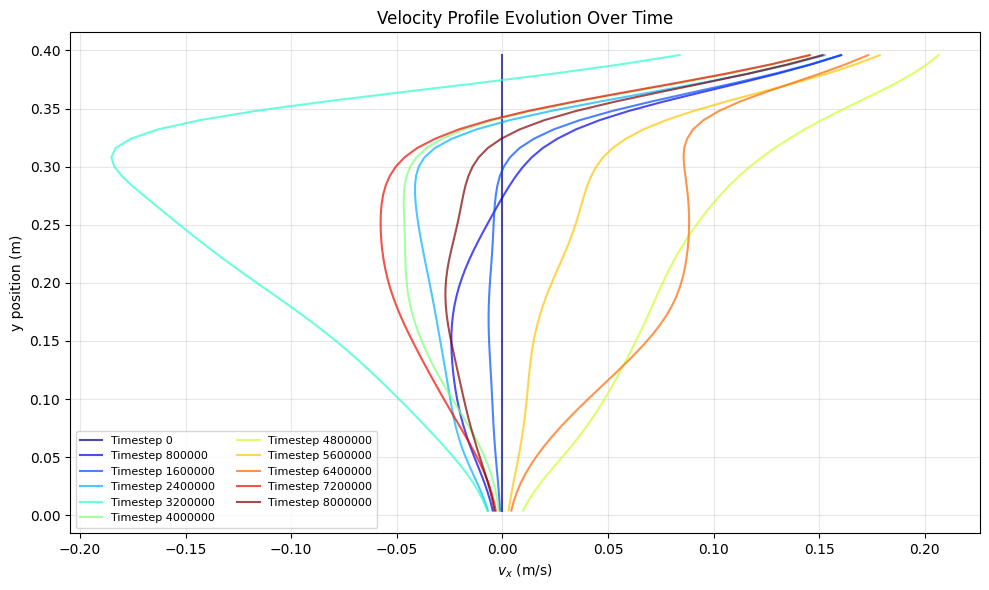

In [2]:
#if __name__ == "__main__":
#     # Initialize coarse-grainer
#     # Use raw string (r"...") or forward slashes for Windows paths
#     cg = GoldhirschWeinhartCoarseGrainer(
#         folder_path=r"F:\DATA_constant_volume_DEM\DATA_constant_volume\vf578_vt0.014",
#         pattern="Dump.shear_fixed_Load_1wall.*",
#         max_frames=10000
#     )
    
#     # Read dump files
#     frames = cg.read_all_frames()

#     frame = frames[-1]
    
#     # Create grid with auto-estimated spacing
#     print("\n=== Creating grid ===")
#     grid_points, grid_shape = cg.create_grid(frame)
    
#     # Coarse-grain velocity (w is auto-estimated)
#     print("\n=== Coarse-graining velocity field ===")
#     velocity_field, density_field = cg.coarse_grain_velocity(
#         frame, grid_points, kernel_type=None
#     )
    
#     print(f"\nResults:")
#     print(f"  Non-zero grid points: {np.sum(density_field > 0)}/{len(density_field)}")
#     print(f"  Velocity range: [{np.min(velocity_field):.6f}, {np.max(velocity_field):.6f}]")
    
#     # Plot 2D field
#     print("\n=== Plotting 2D velocity field ===")
#     fig1 = cg.plot_velocity_profile(
#         frame, velocity_field, grid_points, grid_shape,
#         component=0  # x-component
#     )
    
#     # Compute and plot 1D profile (useful for shear flows)
#     print("\n=== Computing 1D velocity profile ===")
#     bin_centers, vel_profile, vel_std, counts = cg.compute_velocity_profile(
#         frame, 
#         direction='y',  # Bin along y-direction
#         velocity_component='x',  # Look at vx
#         n_bins=50
#     )
    
#     fig2 = cg.plot_1d_velocity_profile(
#         bin_centers, vel_profile, vel_std, counts,
#         direction='y', velocity_component='x'
#     )
    
#     plt.show()
if __name__ == "__main__":
    # Initialize coarse-grainer
    # Use raw string (r"...") or forward slashes for Windows paths
    cg = GoldhirschWeinhartCoarseGrainer(
        folder_path=r"F:\DATA_constant_volume_DEM\DATA_constant_volume\vf601_vt0.23",
        pattern="Dump.shear_fixed_Load_1wall.*",
        max_frames=10000
    )
    
    # Read dump files
    frames = cg.read_all_frames()
    
    # Select frames to overlay (e.g., every 10th frame)
    frame_indices = np.arange(0, len(frames), len(frames)//10)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Color map for time progression
    colors = plt.cm.jet(np.linspace(0, 1, len(frame_indices)))
    
    print("\n=== Processing and plotting all frames ===")
    for idx, frame_idx in enumerate(frame_indices):
        frame = frames[frame_idx]
        
        # Compute 1D velocity profile
        bin_centers, vel_profile, vel_std, counts = cg.compute_velocity_profile(
            frame, direction='y', velocity_component='x', n_bins=50
        )
        
        # Plot with color indicating time
        ax.plot(vel_profile, bin_centers, 
                color=colors[idx], 
                alpha=0.7,
                label=f'Timestep {frame["timestep"]}')
    
    ax.set_xlabel('$v_x$ (m/s)')
    ax.set_ylabel('y position (m)')
    ax.set_title('Velocity Profile Evolution Over Time')
    ax.legend(loc='best', fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [13]:
dy = bin_centers[1] - bin_centers[2]
D = np.zeros(50)
for i in range(50):
    if i == 0:
        D[i] = (vel_profile[i+1] - vel_profile[i])/dy
    elif i == 49:
        D[i] = (vel_profile[i] - vel_profile[i-1])/dy
    else:
        D[i] = (vel_profile[i+1] - vel_profile[i-1])/(2*dy)
D

array([ 0.11120377,  0.12164116,  0.14191835,  0.15938748,  0.17132867,
        0.17637996,  0.17477657,  0.16818306,  0.15983104,  0.15031331,
        0.14032395,  0.13236385,  0.1265843 ,  0.12300431,  0.12156124,
        0.12139419,  0.12117477,  0.11925234,  0.11382263,  0.10347265,
        0.08748909,  0.06583855,  0.03908292,  0.00845662, -0.02433941,
       -0.05708466, -0.08681914, -0.11059828, -0.12595228, -0.13150436,
       -0.12818916, -0.11967126, -0.11111586, -0.10879209, -0.11968968,
       -0.15018061, -0.20790472, -0.30333923, -0.44937855, -0.6659241 ,
       -0.93757569, -1.27519089, -1.68657004, -2.10318545, -2.44361395,
       -2.63153018, -2.6325458 , -2.47034188, -2.20486258, -2.05481188])